In [40]:
from pygeoinf.interval.function_providers import NormalModesProvider, BumpFunctionProvider, SineFunctionProvider, HatFunctionProvider
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.interval.l2_space import L2Space
from pygeoinf.hilbert_space import EuclideanSpace
from pygeoinf.interval.operators import SOLAOperator
from pygeoinf.interval.functions import Function
from pygeoinf.gaussian_measure import GaussianMeasure
import matplotlib.pyplot as plt
import numpy as np
from pygeoinf.interval.boundary_conditions import BoundaryConditions
from pygeoinf.interval.operators import LaplacianInverseOperator
from pygeoinf.forward_problem import LinearForwardProblem
from pygeoinf.linear_bayesian import LinearBayesianInference
from pygeoinf.linear_solvers import CholeskySolver
from pygeoinf.interval.providers import BasisProvider
# Set-up folder for saving figures
import os
figures_folder = 'pli_figures'
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)

In [41]:
# Create a function domain and spaces
function_domain = IntervalDomain(0, 1)
bcs = BoundaryConditions(bc_type='dirichlet', left=0, right=0)
# We instantiate a space with no basis because we want to add a custom basis later.
N = 30 # Number of basis fuctions, even though we have not decided yet which will be those basis functions
M = L2Space(N, function_domain, basis_type='none')
# Then we select a function provider that gives us Sine functions as eigenfunctions of the negative laplacian operator
function_provider = HatFunctionProvider(M, homogeneous=True)
# We use this function provider to form the basis provider
basis_provider = BasisProvider(M, function_provider, orthonormal=True, basis_type='hat_homogeneous')
# Now we set this basis provider as that of our space and then our space will officially have a basis
M.set_basis_provider(basis_provider)

Basis provider set successfully. Space now has 30 basis functions of type 'hat_homogeneous'.


In [42]:
laplacian = LaplacianInverseOperator(M, bcs, fem_type='general')

Setting up GeneralFEMSolver with 30 basis functions from BasisProvider
Using analytical stiffness matrix computation for hat functions
LaplacianInverseOperator initialized with general FEM solver, dirichlet(left=0, right=0) BCs


In [43]:
C_0_mat = np.zeros((N, N))
for i in range(N):
    phi_i = M.get_basis_function(i)
    for j in range(i, N):
        phi_j = M.get_basis_function(j)
        if i == j:
            C_0_mat[i, i] = M.inner_product(phi_i, laplacian(phi_j))
        else:
            C_0_mat[i, j] = M.inner_product(phi_i, laplacian(phi_j))
            C_0_mat[j, i] = C_0_mat[i, j]

In [ ]:
C_0_mat_ = laplacian.matrix(dense=True)

In [49]:
from scipy.linalg import eigh

print(np.min(eigh(C_0_mat)[0]))
print(np.min(eigh(C_0_mat_)[0]))
print(np.allclose(C_0_mat, C_0_mat.T))
print(np.allclose(C_0_mat_, C_0_mat_.T))

6.011681265775485e-08
-5.960420566945164e-08
True
False


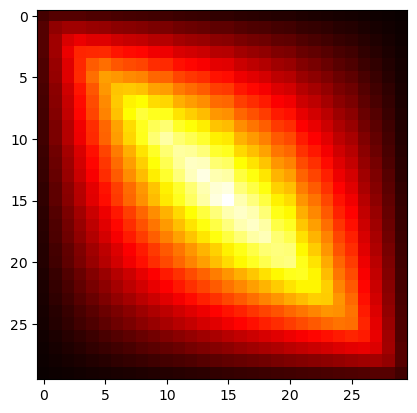

In [46]:
plt.imshow(C_0_mat, cmap='hot', interpolation='nearest')

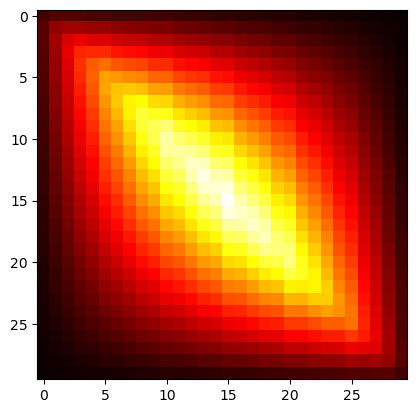

In [47]:
plt.imshow(C_0_mat_, cmap='hot', interpolation='nearest')